In [1]:
import osmnx as ox
ox.__version__

'0.12.1'

In [68]:
ox.utils.config(all_oneway=False)

In [3]:
G_d = ox.graph_from_place('Volgograd', network_type='drive', simplify = False)
G_d = ox.project_graph(G_d)
# fig, ax = ox.plot_graph(G)

In [4]:
# len(G.nodes)

In [5]:
# len(G.edges)

In [6]:
# G_simp = ox.simplify.simplify_graph(G)

In [7]:
# G_simp = ox.project_graph(G_simp)
# fig, ax = ox.plot_graph(G_simp)

In [8]:
# len(G_simp.nodes)

In [9]:
# len(G_simp.edges)

In [10]:
# ox.save_load.save_as_osm(G,node_tags=['highway'], node_attrs=['id', 'lat', 'lon'], edge_tags=['highway', 'lanes', 'maxspeed', 'oneway'], edge_attrs=['id'], oneway=False, merge_edges=True, edge_tag_aggs=None, filename='graph.osm', folder=None)

In [11]:
ox.utils.config(all_oneway=False)

In [12]:
G_ox = ox.core.graph_from_file('graph.osm',  simplify=False, retain_all=True)

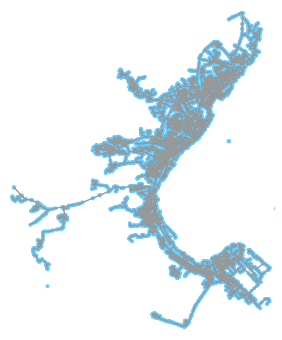

In [13]:
G_ox = ox.project_graph(G_ox)
# fig, ax = ox.plot_graph(G_ox)

In [14]:
len(G_ox.nodes)

40767

In [15]:
len(G_ox.edges)

85090

In [16]:
# print([node for node, data in G_ox.nodes(data=True)].count(5244338902))

In [17]:
nodes_id = [node for node in G_ox.nodes]

In [18]:
nodes_data = G_ox.nodes(data=True)

In [169]:
nodes_data[1688220386]

{'y': 5401682.772721899,
 'x': 455351.7276346223,
 'osmid': 1688220386,
 'highway': 'nan',
 'lon': 44.3924047,
 'lat': 48.7665496}

In [20]:
import networkx as nx

In [21]:
import csv
from lxml import etree as et
from random import choices, random

In [22]:
f = open('100houses.txt', 'r')
houses_id = [house[:-1] for house in f.readlines()]
f.close()
f = open('10med.txt', 'r')
med_id = [med[:-1] for med in f.readlines()]
f.close()
print(len(houses_id))
print(len(med_id))

100
10


In [23]:
houses_id[0]

'5308930859'

In [24]:
#Добавим сначала то, что есть в графе, потом дополним

osm_file = 'graph.osm'
G = nx.DiGraph()
context = et.iterparse(osm_file, events=('end',), tag='node')
nodes = []
for event, elem in context:
    nodes.append(elem.get('id'))
    elem.clear()
    while elem.getprevious() is not None:
        del elem.getparent()[0]
del context
G.add_nodes_from(nodes)
for h in houses_id:
    G.nodes[h]['building'] = 'house'
for m in med_id:
    G.nodes[m]['building'] = 'hospital'
G.number_of_nodes()

40767

In [25]:
def distance(node1,node2):
    x1 = nodes_data[int(node1)]['x']
    y1 = nodes_data[int(node1)]['y']
    x2 = nodes_data[int(node2)]['x']
    y2 = nodes_data[int(node2)]['y']
    distance = ((x1-x2)**2 + (y1-y2)**2)**0.5
    return distance

In [26]:
context = et.iterparse(osm_file,events=('end',),tag='way')
edges = []
for event, elem in context:
    oneway = 0
    #Определим свойства
    for child in elem.iterchildren('tag'):
        key = child.get('k')      
        #Возможно, дорога односторонняя
        if key == 'oneway' and child.get('v') == 'yes':
            oneway = 1
    #Узнаем, какие вершины состоят в пути
    nodes_list = []
    for child in elem.iterchildren('nd'):
        _id = child.get('ref')
        nodes_list.append(child.get('ref'))
    #Добавляем ребра с весами в список смежности
    for i in range(len(nodes_list)-1):
        from_node, to_node = nodes_list[i:i+2]
        d = distance(from_node, to_node)
        edges.append((from_node, to_node, {'weight': d}))
        edges.append((to_node, from_node, {'weight': d}))
    elem.clear()
    while elem.getprevious() is not None:
        del elem.getparent()[0]
del context

G.add_edges_from(edges)
G.number_of_edges()

90150

In [27]:
nodes_id = [str(node) for node in G_ox.nodes]
nodes_data = G_ox.nodes(data=True)

In [28]:
nodes_id.count(houses_id[1])

1

In [29]:
#Добавим ребра к домам и больницам
nearest_nodes_id = []
copy_id = nodes_id
for h_id in houses_id:
    nni = '' #nearest_node_id
    min_dist = float('inf')
    while copy_id.count(h_id) > 0:
        copy_id.remove(h_id)
    for node_id in copy_id:
        d = distance(h_id,node_id)
        if d < min_dist:
            min_dist = d
            nni = node_id
    w = 1 + random()
    nearest_nodes_id.append((nni, h_id, {'weight': min_dist*w}))
    nearest_nodes_id.append((h_id, nni, {'weight': min_dist*w}))
        

copy_id = nodes_id   
for m_id in med_id:
    nni = '' #nearest_node_id
    min_dist = float('inf')
    while copy_id.count(m_id) > 0:
        copy_id.remove(m_id)
    for node_id in copy_id:
        d = distance(m_id,node_id)
        if d < min_dist:
            min_dist = d
            nni = node_id
    w = 1 + random()
    nearest_nodes_id.append((nni, m_id, {'weight': min_dist*w}))
    nearest_nodes_id.append((m_id, nni, {'weight': min_dist*w}))
len(nearest_nodes_id)

220

In [30]:
G.add_edges_from(nearest_nodes_id)

G.number_of_edges()

90370

In [31]:
#Создадим список смежности
# nx.readwrite.adjlist.write_adjlist(G,'adj_list.csv')

In [32]:
# with open('adj_list2.csv','w',newline='') as csv_file:
#     csv_file.write('from_id to_id,edge_weight\n')
#     for _from in list(G.nodes):
#         s = str(_from)
#         for _to in G.successors(_from):
#             s = s + ' ' + str(_to) + ',' + str(G[_from][_to]['weight'])
#         csv_file.write(s + '\n')


In [33]:
#nx.linalg.graphmatrix.adjacency_matrix(G)

In [34]:
# #Создадим матрицу смежности
# adj_matrix = nx.to_pandas_adjacency(G)
# adj_matrix.to_csv('adj_matrix.csv')

In [35]:
# print(adj_matrix)

In [36]:
# matrix = adj_matrix.values
# print(matrix)

In [37]:
class MinNodeHeap:

    def __init__(self,g={}):
        self.heap = []
        self.size = 0
        self.g = g

    def left_index(self,i):
        return 2*i+1

    def right_index(self,i):
        return 2*i+2

    def parent_index(self,i):
        return (i-1)//2

    def min_heapify(self,i):
        l = self.left_index(i)
        r = self.right_index(i)

        if l < self.size and self.g[self.heap[l]]['weight'] < self.g[self.heap[i]]['weight']:
            smallest = l
        else:
            smallest = i
        if r < self.size and self.g[self.heap[r]]['weight'] < self.g[self.heap[smallest]]['weight']:
            smallest = r
        if smallest != i:
            self.g[self.heap[i]]['index'], self.g[self.heap[smallest]]['index'] = self.g[self.heap[smallest]]['index'], self.g[self.heap[i]]['index']           
            self.heap[i], self.heap[smallest] = self.heap[smallest], self.heap[i]
            self.min_heapify(smallest)

    def build_min_heap(self,_NodeView):
        self.heap = [None for i in range(len(_NodeView))]
        for elem in self.g.keys():
            self.heap[self.g[elem]['index']] = elem
#         self.heap = list(_NodeView)
        self.size = len(_NodeView)
#         for i in range(len(_NodeView)//2,-1,-1):
#             self.min_heapify(i)
            
    def extract_min(self):
        if self.size < 1:
            return None
        _min = self.heap[0]
        self.g[self.heap[self.size-1]]['index'] = self.g[self.heap[0]]['index']
        self.heap[0] = self.heap[self.size-1]      
        self.size -= 1
        self.min_heapify(0)
        return _min
    
    def decrease_key(self,_id,key):
        i = self.g[_id]['index']
        if key > self.g[_id]['weight']:
            raise KeyError
        self.g[_id]['weight'] = key
        while (i > 0) and (self.g[self.heap[self.parent_index(i)]]['weight'] > self.g[self.heap[i]]['weight']):
            self.g[self.heap[self.parent_index(i)]]['index'], self.g[self.heap[i]]['index'] = self.g[self.heap[i]]['index'], self.g[self.heap[self.parent_index(i)]]['index']
            self.heap[self.parent_index(i)], self.heap[i] = self.heap[i], self.heap[self.parent_index(i)]
            i = self.parent_index(i)


In [38]:
def initialize_single_sourse(G,_from):
    g = {}
    nodes_list = list(G.nodes).copy()
    nodes_list.remove(_from)
    for v_id, i in zip(nodes_list,range(1,len(G.nodes))):
        g[v_id] = {'way': [], 'weight':float('inf'), 'index':i}
    g[_from] = {'way':[_from], 'weight':0, 'index':0}
    return g

def relax(G,min_heap,_from,_to):
    if min_heap.g[_to]['weight'] > min_heap.g[_from]['weight'] + G[_from][_to]['weight']:
        key = min_heap.g[_from]['weight'] + G[_from][_to]['weight']
        min_heap.decrease_key(_to,key)
        min_heap.g[_to]['way'] = (min_heap.g[_from]['way']).copy()
        min_heap.g[_to]['way'].append(_to)
        
def dijkstra(G,_from,to_list):
    g = initialize_single_sourse(G,_from)
    finish = 0
    nodes = MinNodeHeap(g)
    nodes.build_min_heap(G.nodes)
    while nodes.size > 0 and finish < len(to_list):
        u = nodes.extract_min()
        if to_list.count(u) > 0:
            finish += 1
        for v in G.successors(u):
            relax(G,nodes,u,v)
    return g


In [39]:
# ok = nx.DiGraph()
# ok.add_nodes_from(['2', '1', '3', '4', '5', '6'])
# to_list = ['4','2']
# ok.add_edges_from([('1','2', {'weight': 1}), ('1','3', {'weight': 2}), ('3','4', {'weight': 5}), ('4','5', {'weight': 6}), ('5','6', {'weight': 10}), ('2','7', {'weight': 100}), ('7','8', {'weight': 3})])

In [40]:
# g = initialize_single_sourse(ok, '1')
# finish = 0
# nodes = MinNodeHeap(g)
# nodes.build_min_heap(ok.nodes)
# while nodes.size > 0 and finish < len(to_list):
#     u = nodes.extract_min()
#     if to_list.count(u) > 0:
#         finish += 1
#     for v in ok.successors(u):
#         relax(ok,nodes,u,v)  
# g

In [41]:
# d = dijkstra(ok,'1',['2','4'])
# d

In [42]:
# a = dijkstra(G,houses_id[0],med_id)
# (a)

In [43]:
# #Запустим Дейкстру от всех домов и больниц, сохраним результаты для выполнения заданий
# houses_res = []
# for h_id in houses_id:
#     houses_res.append(dijkstra(G,h_id,med_id))
# med_res = []
# for m_id in med_id:
#     houses_res.append(dijkstra(G,m_id,houses_id))
# #15 минут работы

In [44]:
# #Вариант с записью на диск работает дольше, но его нужно выполнить 1 раз
# with open('ways_from_houses.txt','w',newline='') as f:
#     f.write('from_id,to_id,way_weight,way\n')
#     for h_id in houses_id:
#         a = dijkstra(G,h_id,med_id)
#         for m_id in med_id:
#             s = h_id + ',' + m_id + ',' + str(a[m_id]['weight'])
#             if a[m_id]['way'] != '':
#                 way = ','.join(a[m_id]['way'])
#                 s = s + ',' + way
#             f.write(s + '\n')


In [45]:
# with open('ways_from_med.txt','w',newline='') as f:  
#     f.write('from_id,to_id,way_weight,way\n')
#     for m_id in med_id:        
#         a = dijkstra(G,m_id,houses_id)
#         for h_id in houses_id:                
#             s = m_id + ',' + h_id + ',' + str(a[h_id]['weight'])
#             if a[h_id]['way'] != '':
#                 way = ','.join(a[h_id]['way'])
#                 s = s + ',' + way
#             f.write(s + '\n')


In [46]:
# G['5308930859']

In [47]:
# min_ways = {}
# with open('ways_from_houses.txt','r') as f:  
#     next(f)
#     for line in f:
#         split_line = line.split(',')
#         _from = split_line[0]
#         _to = split_line[1]
#         weight = split_line[2]
#         if min_ways.get(_from) == None:
#             min_ways[_from] = {'to':_to,'weight':weight}
#         elif min_ways[_from]['weight'] > weight:
#             min_ways[_from]['weight'] = weight
#             min_ways[_from]['to'] = _to

# with open('shortest_ways_from_houses.txt','w',newline='') as f:  
#     f.write('from_id,to_id,way_weight\n')
#     s = ''
#     for h_id in min_ways.keys():
#         s = s + h_id + ',' + min_ways[h_id]['to'] + ',' + min_ways[h_id]['weight']+'\n'
#     f.write(s)

In [48]:
# min_ways = {}
# with open('ways_from_med.txt','r') as f:  
#     next(f)
#     for line in f:
#         split_line = line.split(',')
#         _from = split_line[0]
#         _to = split_line[1]
#         weight = split_line[2]
#         if min_ways.get(_from) == None:
#             min_ways[_from] = {'to':_to,'weight':weight}
#         elif min_ways[_from]['weight'] > weight:
#             min_ways[_from]['weight'] = weight
#             min_ways[_from]['to'] = _to
                                 
# with open('shortest_ways_from_med.txt','w',newline='') as f:  
#     f.write('from_id,to_id,way_weight\n')
#     s = ''
#     for h_id in min_ways.keys():
#         s = s + h_id + ',' + min_ways[h_id]['to'] + ',' + min_ways[h_id]['weight']+'\n'
#     f.write(s)
        

In [49]:
# with open('ways_from_med.txt','r') as f:
#     lines = f.readlines()
#     lines = lines[1:]
#     med_lines = []
#     for elem in lines:
#         split_line = elem.split(',')
#         med_lines.append(split_line)
#     med_dict = {}
#     for elem in med_lines:
#         med_dict[elem[0]] = {}
#         med_dict[elem[0]][elem[1]] = elem[2]
        
# with open('ways_from_houses.txt','r') as f:  
#     lines = f.readlines()
#     lines = lines[1:]
#     houses_lines = []
#     for elem in lines:
#         split_line = elem.split(',')
#         houses_lines.append(split_line)
#     houses_dict = {}
#     for elem in houses_lines:
#         houses_dict[elem[0]] = {}
#         houses_dict[elem[0]][elem[1]] = elem[2]

# min_way = {'med': '','house': '','weight': float('inf')}
# for m in med_id:
#     for h in houses_id:  
#         print(med_dict)
#         if min_way['weight'] > med_dict[m][h] + houses_dict[h][m]:
#             min_way['weight'] = med_dict[m][h] + houses_dict[h][m]
#             min_way['med'] = m
#             min_way['house'] = h
        
# print(min_way)

In [50]:
# max_weight = 10000

In [51]:
# ways = []
# with open('ways_from_houses.txt','r') as f:  
#     next(f)
#     for line in f:
#         split_line = line.split(',')
#         _from = split_line[0]
#         _to = split_line[1]
#         weight = split_line[2]
#         if weight < max_weight:
#             ways.append([_from,_to,weight])

# with open('near_houses.txt','w',newline='') as f:  
#     f.write('from_id,to_id,weight\n')
#     s = ''
#     for way in ways:
#         s = s + way[0] + ',' + way[1] + ',' + way[2] +'\n'
#     f.write(s)

In [52]:
# ways = []
# with open('ways_from_med.txt','r') as f:  
#     next(f)
#     for line in f:
#         split_line = line.split(',')
#         _from = split_line[0]
#         _to = split_line[1]
#         weight = split_line[2]
#         if weight < max_weight:
#             ways.append([_from,_to,weight])

# with open('near_med.txt','w',newline='') as f:  
#     f.write('from_id,to_id,weight\n')
#     s = ''
#     for way in ways:
#         s = s + way[0] + ',' + way[1] + ',' + way[2] +'\n'
#     f.write(s)
      

In [53]:
# with open('ways_from_med.txt','r') as f:  
#     med_lines = [elem.split(',') for elem in f.readlines()[1:]]
#     med_dict = {elem[0]:{elem[1]:elem[2]} for elem in med_lines}
    
# with open('ways_from_houses.txt','r') as f:  
#     houses_lines = [elem.split(',') for elem in f.readlines()[1:]]
#     houses_dict = {elem[0]:{elem[1]:elem[2]} for elem in houses_lines}                          

# ways = []
# for m in med_id:
#     for h in houses_id:
#         if med_dict[m][h] + houses_dict[h][m] < max_weight:
#             ways.append([med_dict[m][h] + houses_dict[h][m], m, h])

# with open('near_med.txt','w',newline='') as f:
#     f.write('med_id, house_id,weight\n')
#     s = ''
#     for way in ways:
#         s = s + way[0] + ',' + way[1] + ',' + way[2] +'\n'
#     f.write(s)
              

In [54]:
# #Выбираем минимум из максимумов
# minmax_way = {'from':'','to':'','weight':float('inf')}
# for m_id in med_id:
#     weight = 0
#     for h_id in house_id:
#         if med_dict[m_id][h_id] > weight:
#             weight = med_dict[m_id][h_id]
#             _from = m_id
#             _to = h_id
#     if weight < minmax_way['weight']:
#         minmax_way['weight'] = weight
#         minmax_way['from'] = _from
#         minmax_way['to'] = _to


In [55]:
# min_sum = float('inf')
# _from = ''
# for m_id in med_id:
#     sum = 0
#     for h_id in house_id:        
#         sum += med_dict[m_id][h_id]
#     if sum < min_sum:
#         min_sum = sum
#         _from = m_id
        

In [56]:
# def task1_2():
    #Определить, какой из объектов расположен так, что время/расстояние между ним и
    #самым дальним домом минимально (“туда”, “обратно”, “туда и обратно”)
    

In [57]:
# def task1_3():
#     #Для какого объекта инфраструктуры сумма кратчайших расстояний от него до всех домов минимальна
    

In [58]:

def get_edge_weight(edge, tree):
    prev_weight = float(tree[edge['from']]['weight'])
    post_weight = float(tree[edge['to']]['weight'])
    return post_weight - prev_weight
# fig, ax = ox.plot_graph_route(G_ox, route)

In [59]:
import math
def get_tree_and_sum(G, _from, target_list):
    tree = dijkstra(G, _from, target_list)
    filtered_tree = {k:v for k,v in tree.items() if not math.isinf(v["weight"]) and k in target_list}
    tree_sum = sum(list(map(lambda x: x['weight'], list(filtered_tree.values()))))
    
    edge_set = list()
    for target in filtered_tree:
        node_list = filtered_tree[target]['way']
        for node_number in range(len(node_list)-2):           
            new_edge = {"from": node_list[node_number], "to": node_list[node_number + 1]}
            if new_edge not in edge_set:
                edge_set.append(new_edge)
    tree_small_sum = sum(list(map(lambda x: get_edge_weight(x, tree), edge_set)))
    return filtered_tree, tree_sum, tree_small_sum

temp_nodes_id = houses_id
temp_med_id = med_id[5]

temp_tree, temp_tree_sum, temp_tree_small_sum = get_tree_and_sum(G,temp_med_id, temp_nodes_id)

print(temp_tree_sum)
print(temp_tree_small_sum)

3449346.903896833
225076.44264418396


In [181]:
def get_centroid_coords(cluster_nodes):
    x = sum(list(map(lambda x: x['x'], cluster_nodes))) / len(cluster_nodes)
    y = sum(list(map(lambda x: x['y'], cluster_nodes))) / len(cluster_nodes)
    return x, y

In [70]:
routes_temp = [temp_tree[key]['way'] for key in temp_tree]
routes_temp_2 = list(map(lambda x: [int(value) for value in x][2:-8], routes_temp))



# fig, ax = ox.plot_graph_routes(G_ox, routes_temp_2)
# fig, ax = ox.plot_graph(G)


100

In [73]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

In [ ]:
import collections
matrix = []
for house_id in houses_id:
    pre_vector = dijkstra(G, house_id, houses_id)
    filtered_vector = {k:v for k,v in pre_vector.items() if not math.isinf(v["weight"]) and k in houses_id}
    sorted_vector = collections.OrderedDict(sorted(filtered_vector.items()))
    vector = list(map(lambda x: x['weight'], list(sorted_vector.values())))
    matrix.append(vector)

In [160]:
 def cluster_to_id_list(cluster_index, cluster_cash, list_id, count_of_values):
    cluster_indexes = [cluster_index]
    while len(list(filter(lambda x: x > count_of_values, cluster_indexes))) > 0:
        
        cluster_to_open = list(filter(lambda x: x >= count_of_values, cluster_indexes))
        
        for cluster in cluster_to_open:
            cluster_indexes.remove(cluster)
            cluster_indexes.append(cluster_cash[int(cluster) - count_of_values, 0] )
            cluster_indexes.append(cluster_cash[int(cluster) - count_of_values, 1] )
            
    return list(map(lambda x: list_id[int(x)], cluster_indexes))    

In [183]:
#Для 2 кластеров развернем в индексы node
first_cluster = cluster_cash[-1,0] 
first_cluster_nodes = cluster_to_id_list(first_cluster, cluster_cash, houses_id, len(houses_id))

list_with_coords = list(map(lambda x: {'x': float(nodes_data[int(x)]['x']), 'y': float(nodes_data[int(x)]['y'])} ,first_cluster_nodes))

first_centroid = get_centroid_coords(list_with_coords)

# first_centroid_id = get_id(first_centroid)
# first_tree, first_tree_sum, first_little_sum = get_tree_and_sum(G, first_centroid_id, first_cluster_nodes)


(473165.5082589862, 5397282.960082818)


In [75]:
import numpy as np
matrix_np = np.array(matrix)


2

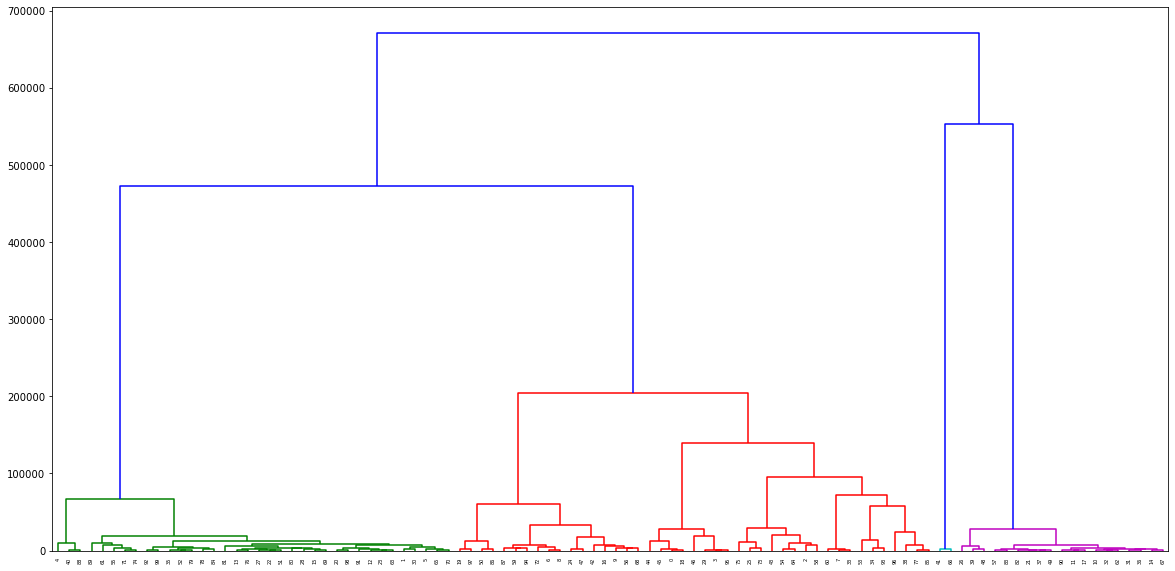

In [78]:
cluster_cash = linkage(matrix_np, 'complete')
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(cluster_cash)

In [84]:
cluster_cash[-1,:]

array([1.96000000e+02, 1.97000000e+02, 6.71867508e+05, 1.00000000e+02])

2